## Load data

In [1]:
!wget http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
!unzip final_project.zip

--2022-12-03 18:34:57--  http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444833 (434K) [application/zip]
Saving to: ‘final_project.zip’

final_project.zip   100%[===================>] 434,41K  2,20MB/s    in 0,2s    

2022-12-03 18:34:59 (2,20 MB/s) - ‘final_project.zip’ saved [444833/444833]

Archive:  final_project.zip
   creating: starter_code/
  inflating: starter_code/majority_vote.py  
  inflating: starter_code/utils.py   
   creating: starter_code/part_a/
  inflating: starter_code/part_a/item_response.py  
  inflating: starter_code/part_a/__init__.py  
  inflating: starter_code/part_a/knn.py  
  inflating: starter_code/part_a/matrix_factorization.py  
  inflating: starter_code/part_a/ensemble.py  
  inflating: starter_code/part_a/neural_network.

In [1]:
import sys
sys.path.append('starter_code/')

In [2]:
from utils import *

In [3]:
train_data = load_train_csv("starter_code/data")
valid_data = load_valid_csv("starter_code/data")
test_data = load_public_test_csv("starter_code/data")

In [4]:
type(train_data)

dict

In [5]:
train_data.keys()

dict_keys(['user_id', 'question_id', 'is_correct'])

In [6]:
len(set(train_data["user_id"])), min(set(train_data["user_id"])), max(set(train_data["user_id"]))

(542, 0, 541)

In [7]:
train_matrix = load_train_sparse("starter_code/data")
train_matrix.shape, (train_matrix.shape[0]*train_matrix.shape[0]/2 - train_matrix.shape[0]/2)

((542, 1774), 146611.0)

## Distance calculation

To merge students into clusters, we need to calculate the distance between them first. The possible problem that arises is how to measure the distance between two students that did not answer the same questions, i.e. two sets of questions does not intersect. The most straight-forward idea is to set the minimum distance (zero) assuming that if the questions do not conflict, they are in consistency. In this project, I test the methodology of calculating the distance between students that does not have common questions through other students. To do this, I create the graph of students as a node and distance as a weight of the edge. Later on, to calculate the distance between students that are not merged by edge, we find the shortest path between them through others.

Even if the two students have only one question in common, is it enough to calculate the distance between them? That's why I introduce parameter N - the minimum common questions to calculate the distance.

In [1]:
from scipy.spatial.distance import pdist, cdist, cosine
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def my_dist_euclidian(x,y,N = 0):
    newx = x[~np.isnan(x)&~np.isnan(y)]
    newy = y[~np.isnan(x)&~np.isnan(y)]
    if len(newx) <= N or len(newy) <= N: ## ==0
        return np.nan
    return np.nanmean((x-y)**2)

def my_dist_cosine(x,y,N = 0):
    newx = x[~np.isnan(x)&~np.isnan(y)]
    newy = y[~np.isnan(x)&~np.isnan(y)]
    if len(newx) <= N or len(newy) <= N: ## ==0
        return np.nan
    return cosine(newx, newy)

In [15]:
def eucl(l1,l2):
    x = np.array(l1)
    y = np.array(l2)
    return np.nanmean((x-y)**2)

I used two possible distances - the euclidean and cosine. To understand them, here are a few examples. Cosine distance considers lists as vectors, therefore the meaning of 0 is tricky. As we see, when an additional zero is added to both lists, cosine distance does not change. But if an additional 1 is added, the distance is less, that is expected when one more common value comes in play. So if 0 is an incorrect answer and 1 is correct, the problem arises, since distance metric does not account for 0 and 1 in the same way. Euclidean distance does not have this problem, that's why I bet on it on this stage of project.

In [16]:
print("Initial combination:", cosine([1, 1, 1], [1, 1, 0]))
print("Added 0 to each vector:", cosine([1, 1, 1, 0], [1, 1, 0, 0]))
print("Added 1 to each vector:", cosine([1, 1, 1, 1], [1, 1, 0, 1]))
print("Distance with whole 0 vector:", cosine([0, 0, 0], [0, 0, 1]))

print("Initial combination:", eucl([1, 1, 1], [1, 1, 0]))
print("Added 0 to each vector:", eucl([1, 1, 1, 0], [1, 1, 0, 0]))
print("Added 1 to each vector:", eucl([1, 1, 1, 1], [1, 1, 0, 1]))
print("Distance with whole 0 vector:", eucl([0, 0, 0], [0, 0, 1]))

Initial combination: 0.18350341907227397
Added 0 to each vector: 0.18350341907227385
Added 1 to each vector: 0.1339745962155613
Distance with whole 0 vector: nan
Initial combination: 0.3333333333333333
Added 0 to each vector: 0.25
Added 1 to each vector: 0.25
Distance with whole 0 vector: 0.3333333333333333


Later on, I consider using 1 for correct answer and -1 for incorrect. This solved the problem. The lesson to learn is **absence of event is not the same as negative event**. Also, cosine distance consider 0 as the absence of the event, not the negative one. 

In [18]:
print("Initial combination:", cosine([1, 1, 1], [1, 1, -1]))
print("Added 0 to each vector:", cosine([1, 1, 1, -1], [1, 1, -1, -1]))
print("Added 1 to each vector:", cosine([1, 1, 1, 1], [1, 1, -1, 1]))

print("Initial combination:", eucl([1, 1, 1], [1, 1, -1]))
print("Added 0 to each vector:", eucl([1, 1, 1, -1], [1, 1, -1, -1]))
print("Added 1 to each vector:", eucl([1, 1, 1, 1], [1, 1, -1, 1]))

Initial combination: 0.6666666666666667
Added 0 to each vector: 0.5
Added 1 to each vector: 0.5
Initial combination: 1.3333333333333333
Added 0 to each vector: 1.0
Added 1 to each vector: 1.0


In [15]:
def get_graph(dist_matrix):
    G = nx.Graph()

    for i,j in zip(*np.where(~np.isnan(dist_matrix))):
        if i!=j:
            G.add_edge(i, j, weight = -dist_matrix[i][j], dist = dist_matrix[i][j])
            
    assert nx.is_connected(G), "graph is not connected"
    assert G.number_of_edges() == (~np.isnan(dist_matrix)).sum()/2 - dist_matrix.shape[0]/2
    return G

def fill_nan_G(G, dist_matrix):
    missed_paths = {}
    missed_dists = {}
    new_dist_matrix = dist_matrix.copy()
    for i,j in zip(*np.where(np.isnan(dist_matrix))):
        missed_paths[(i, j)] = nx.shortest_path(G, i, j, weight = "dist")
        missed_dists[(i, j)] = nx.path_weight(G, missed_paths[(i, j)], "dist")
        new_dist_matrix[i, j] = missed_dists[(i, j)]
    return new_dist_matrix, missed_dists, missed_paths

0
Time(min): 35.57120016415914


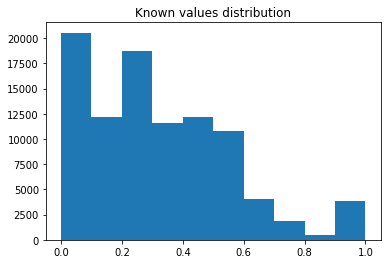

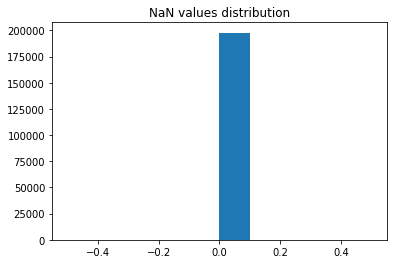

1
Time(min): 37.71334750254949


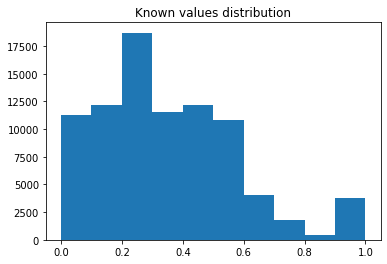

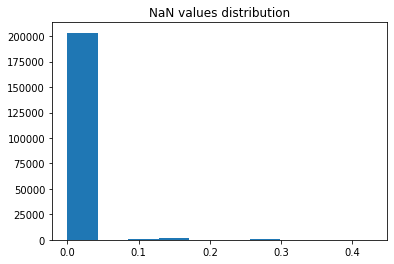

2
Time(min): 70.82111525932947


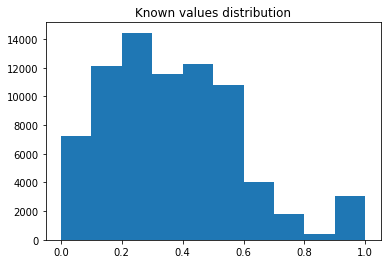

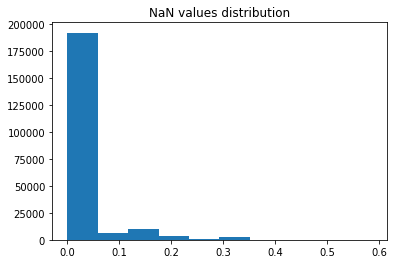

3
Time(min): 69.33010424375534


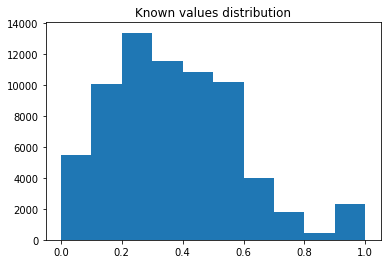

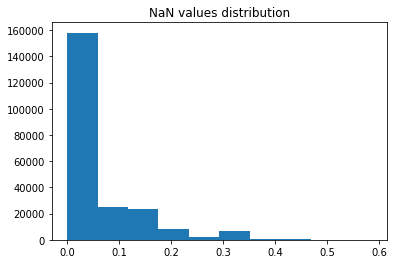

4
Time(min): 52.35387357473373


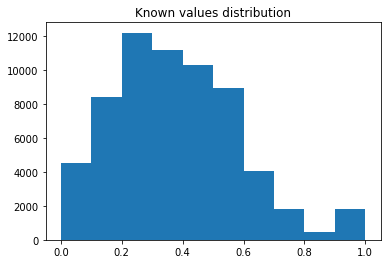

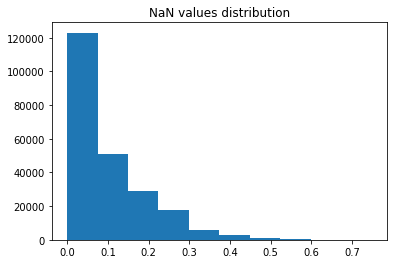

5
Time(min): 32.07121872504552


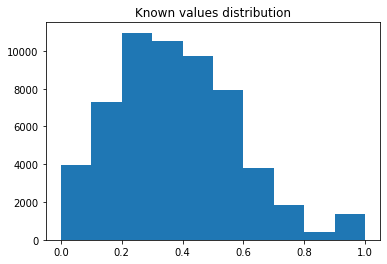

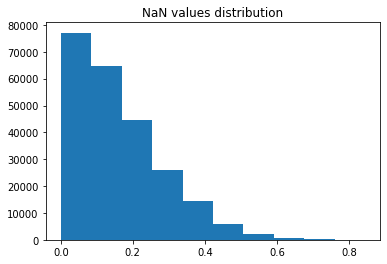

AssertionError: graph is not connected

In [24]:
### cosine distance and N in range(0,10)
import time 
for i in range(0,10):
    start = time.time()
    dist_matrix_n = cdist(train_matrix.toarray(), train_matrix.toarray(), metric = lambda x,y: my_dist_cosine(x,y,i))
    G_n = get_graph(dist_matrix_n)
    
    dist_matrix_filled, _, _ = fill_nan_G(G_n, dist_matrix_n)
    
    print(i)
    print("Time(min):", (time.time()-start)/60)
    pd.DataFrame(dist_matrix_filled).to_csv(f"meta-data/cosine_dist_matrix_{i}.csv", index = False)
    plt.hist(dist_matrix_filled[~np.isnan(dist_matrix_n)])
    plt.title("Known values distribution")
    plt.show()
    plt.hist(dist_matrix_filled[np.isnan(dist_matrix_n)])
    plt.title("NaN values distribution")
    plt.show()

0
Time(min): 37.007076823711394


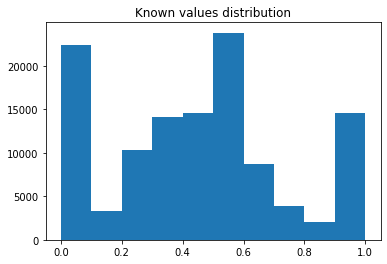

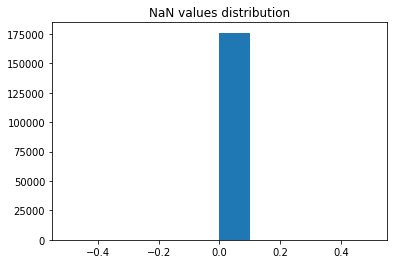

1
Time(min): 36.16051596403122


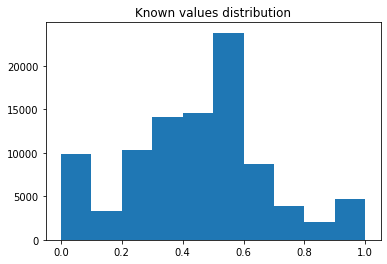

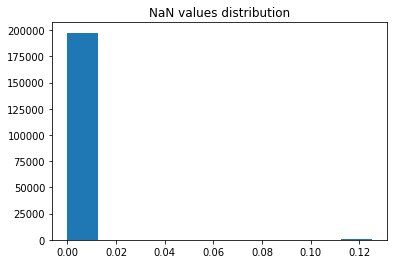

2
Time(min): 34.329918209711714


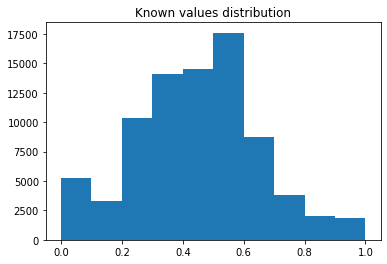

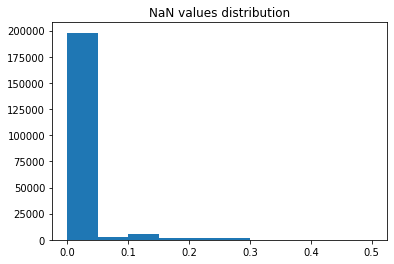

3
Time(min): 32.53846394618352


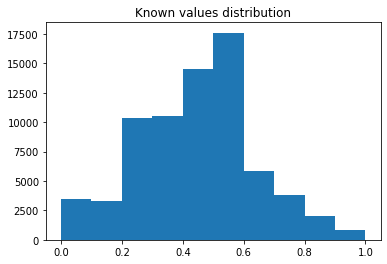

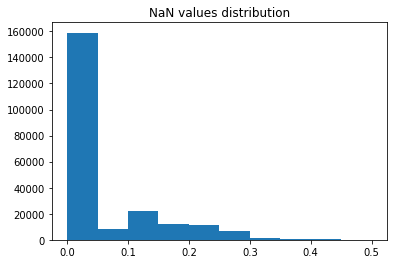

4
Time(min): 29.805493160088858


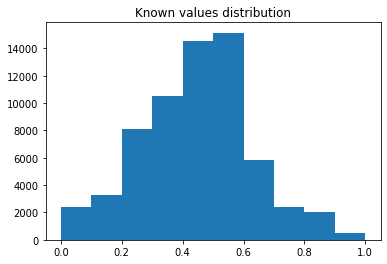

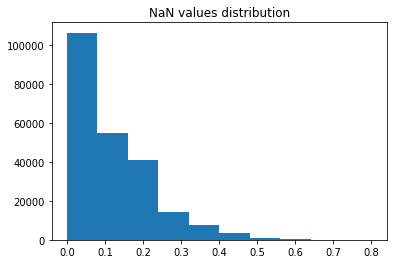

5
Time(min): 27.015429373582204


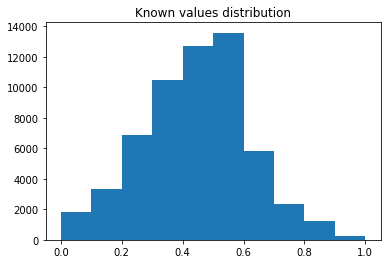

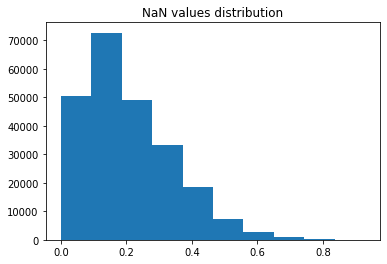

AssertionError: graph is not connected

In [23]:
### euclidean distance and N in range(0,10)
import time 
for i in range(0,10):
    start = time.time()
    dist_matrix_n = cdist(train_matrix.toarray(), train_matrix.toarray(), metric = lambda x,y: my_dist_euclidian(x,y,i))
    G_n = get_graph(dist_matrix_n)
    
    dist_matrix_filled, _, _ = fill_nan_G(G_n, dist_matrix_n)
    
    print(i)
    print("Time(min):", (time.time()-start)/60)
    pd.DataFrame(dist_matrix_filled).to_csv(f"meta-data/dist_matrix_{i}.csv", index = False)
    plt.hist(dist_matrix_filled[~np.isnan(dist_matrix_n)])
    plt.title("Known values distribution")
    plt.show()
    plt.hist(dist_matrix_filled[np.isnan(dist_matrix_n)])
    plt.title("NaN values distribution")
    plt.show()

## Analysis

In [13]:
%%time
G0 = get_graph(dist_matrix0)

CPU times: user 685 ms, sys: 27.8 ms, total: 712 ms
Wall time: 811 ms


In [22]:
dist_matrix_n[np.isnan(dist_matrix_n)]

array([nan, nan, nan, ..., nan, nan, nan])

In [14]:
%%time
G5 = get_graph(dist_matrix5)

CPU times: user 357 ms, sys: 11.9 ms, total: 368 ms
Wall time: 494 ms


In [58]:
np.isnan(dist_matrix0).sum(), np.isnan(dist_matrix5).sum(), len(dist_matrix0)**2

(176188, 235284, 293764)

In [15]:
%%time
dist_matrix0_filled, _, _ = fill_nan_G(G0, dist_matrix0)

CPU times: user 47min 38s, sys: 47.6 s, total: 48min 26s
Wall time: 51min 51s


In [16]:
%%time
dist_matrix5_filled, _, _ = fill_nan_G(G5, dist_matrix5)

CPU times: user 29min 37s, sys: 8.21 s, total: 29min 45s
Wall time: 30min 35s


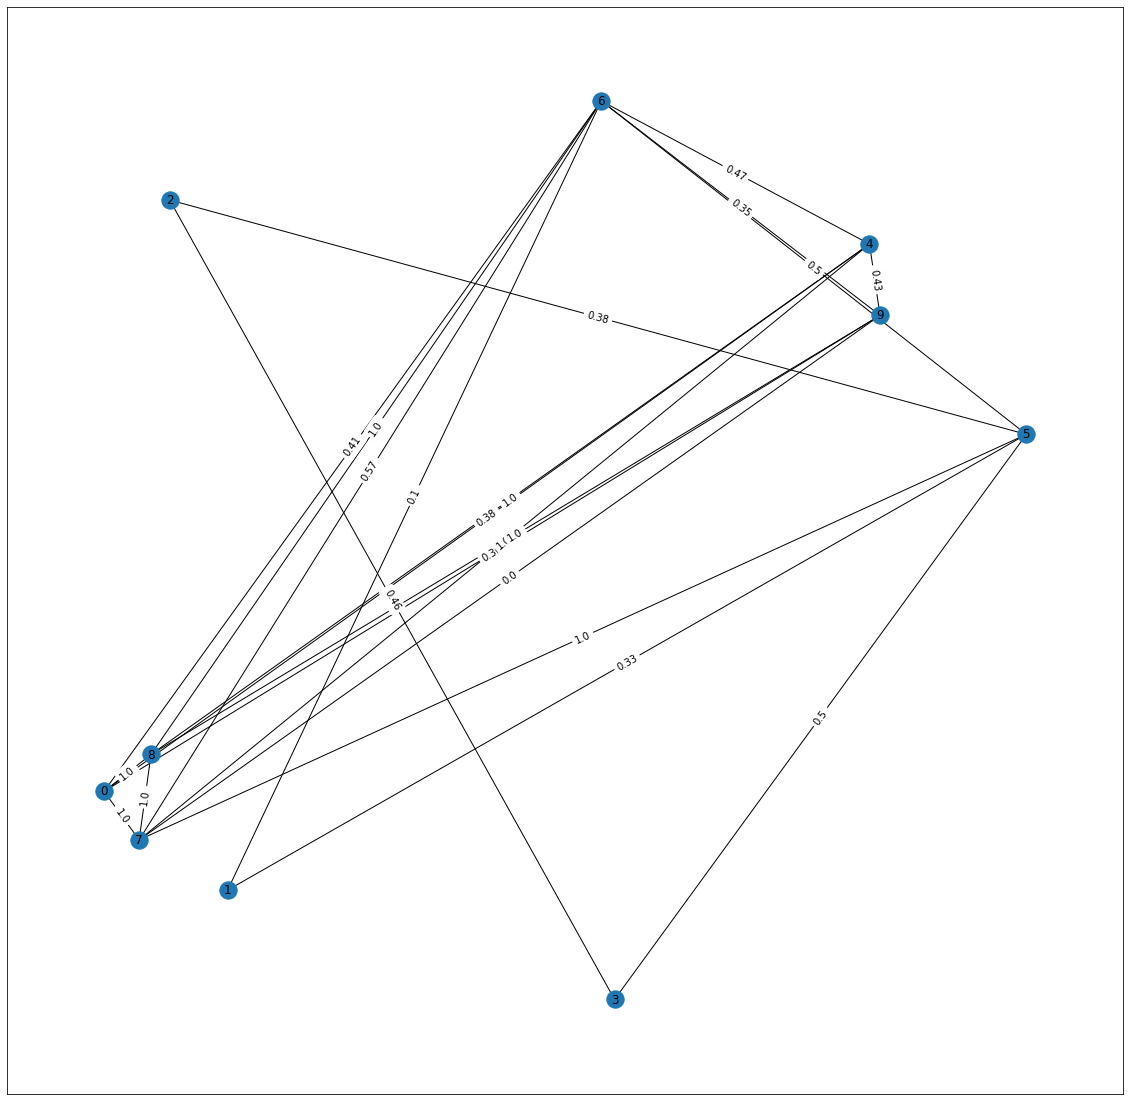

In [84]:
students = range(10)#[1, 229, 504, 295, 388, 0]#[1,0,6]+[0, 33, 1]#range(10)
sub_G = G0.subgraph(students)

plt.figure(figsize = (20,20))

pos=nx.spring_layout(sub_G, weight = 'weight')
nx.draw_networkx(sub_G,pos)
labels = nx.get_edge_attributes(sub_G,'dist')
labels = {k:v.round(2) for k,v in labels.items()}
nx.draw_networkx_edge_labels(G0,pos,edge_labels=labels)

plt.show()

In [27]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(dist_matrix0_filled)

True

In [133]:
def to_vector(dist):
    m = len(dist)
    vector_dist = np.zeros(int(m*m/2-m/2))

    for i in range(m):
        for j in range(i+1,m):
            vector_dist[m * i + j - ((i + 2) * (i + 1)) // 2] = dist[i][j]
    return vector_dist

vector_dist = to_vector(dist_matrix5_filled) #[:10,:10]
vector_dist, len(vector_dist)

(array([0.08333333, 0.11111111, 0.16666667, ..., 0.74444444, 0.91111111,
        0.83333333]),
 146611)

In [134]:
vector_dist[np.where(vector_dist != 0)]

array([0.08333333, 0.11111111, 0.16666667, ..., 0.74444444, 0.91111111,
       0.83333333])

(array([26141., 39986., 30842., 20178., 13502., 10097.,  3712.,  1352.,
          654.,   147.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

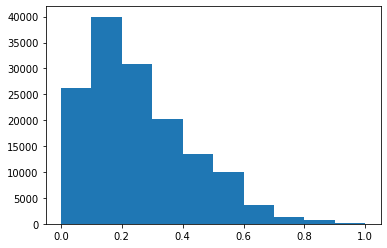

In [135]:
plt.hist(vector_dist)